# 0. Utils

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
import scipy.linalg as la
import os
from scipy.stats import mode
from scipy import stats
import statsmodels.formula.api as smf
import time
import collections as c

def to_num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s

# 1. Load raw data (`data`)

In [3]:
RES = []
print('----start loading----')
for month in ['march', 'april', 'may']:
    file_parts = len(os.listdir(path= '../data/' + month))-1
    for i in range(file_parts):
        fname = '../data/' + month + '/part-' + str(i).rjust(5, '0')
        print('{}: {:.2f}'.format(month, i/file_parts*100), end='%\r')
        with open(fname, 'r') as lines:
            count = 0
            ind_status, ind_pose = False, False
        #     numRows = 0
            for line in lines:
                tmp = line.split()
        #         print(line.split())
                if(tmp[1] == 'aw_idl/VehicleInput'):
                    res = []
                    res.extend(list(map(to_num, tmp)))
                    count += 1
        #             RES.append(res)
                elif(tmp[1] == 'aw_idl/VehicleStatus'):
                    tmp_status = list(map(to_num, tmp))
                    ind_status = True
                elif(count == 1):
                    tmp_pose = list(map(to_num, tmp))
                    ind_pose = True
                    count = 0
                if ind_status and ind_pose:
                    res.extend(tmp_pose)
                    res.extend(tmp_status)
                    RES.append(res)
                    ind_status, ind_pose = False, False
    print(month, end =' done.               \n')
print('----finish loading----')

----start loading----
march done.               
april done.               
may done.               
----finish loading----


In [5]:
cols = ['bag_name', 'topic', 'time', 'input_status', 'cmd', 'steering_input', 'bag_name2', 'topic2', 'time2', 'v', 'acc', 'x', 'y', 'z', 'pitch', 'omega_yaw', 'bag_name3', 'topic3', 'time3', 'system_status', 'speed_status', 'steering_status']
data = pd.DataFrame(RES, columns = cols)
data = data.drop(['topic', 'topic2', 'topic3', 'time2', 'time3'], axis=1)
data = data.sort_values(by = 'time')
data = data.reset_index(drop=True)

In [13]:
n = len(data)
bag_name = data.bag_name
acc = data.acc
v = data.v
cmd = data.cmd
x = data.x
y = data.y
z = data.z
pitch = np.sin(data.pitch)
pitch2 = pitch/abs(pitch).max()
system_status = data.system_status
ts = data.time # timestamp
t = np.array(list(map(lambda x:time.strftime('%Y%m%d%H%M%S', time.localtime(x)), ts)))
dayofyear = np.array(list(map(lambda x:to_num(time.strftime('%j', time.localtime(x))), ts)))
month = np.array(list(map(lambda x:to_num(time.strftime('%m', time.localtime(x))), ts)))
week = np.array(list(map(lambda x:to_num(time.strftime('%W', time.localtime(x))), ts)))

# 2. Extract data by purpose

### brake data

where we have 2 types of braking:

+ cmd change directly from positive to -57

+ cmd change from positive to 0 -> -20 -> -40 -> -57

they are actually equivalent, since the first scenario would also go through the phase (of about 300ms) to increase brake power from 0 to its maximum.

Below we identify braking data by some basic logics:

+ start with `cmd==-57` and `v>eps_move`

+ end if `v<eps_still`

+ filter out invalid samples: 1. `acc==0`; 2. not in the same bag; 3. in manual driving mode;

In [7]:
def extract_brake_idx(data, eps_still=0.03, eps_move=0.3):
    """
    Identify and extract indices of braking samples in a given data frame
    By logic:
    
        start with `cmd==-57` and `v>eps_move`

        end if `v<eps_still`

        filter out invalid samples: 1. `acc==0`; 2. not in the same bag; 3. in manual driving mode;
    Returns: indices of brake samples in the original data frame.
    """

    n = len(data)
    # start: starting idx of brake behavior
    # end: ending idx of brake behavior
    start, end = 0, 0 # starting idx and ending idx
    eps_still = 0.03 # threshold of being still
    eps_move = 0.3 # threshold of driving (initial state)
    ind = 0 # indicator of whether in the process of brake behavior when iterating
    brake_idx = [] # tuples of indices of braking behavior
    for i in range(n):
        if (ind == 0) and (cmd[i] == -57) and (v[i] > eps_move) and (acc[i] != 0):
    #         cmd_tmp = cmd[i] # previous cmd to chech whether cmd increases
            ind = 1
            start = i
        elif ind == 1:
            if cmd[i] > -57:
                ind = 0

        if (v[i] < eps_still) and (ind == 1):
            end = i
            ind = 0
            # status is odd, automated
            if bag_name[start] == bag_name[end] and (mode(system_status[start:end+1])[0] & 1 == 1):
                # 2 ways of controlling braking
                if cmd[start-1]>0:
                    brake_idx.append((start, end))
                elif (cmd[start-3: start] == np.array([0, -20, -40])).all():
                    brake_idx.append((start-3, end))
        if i % 10000 == 0:
            print('Progressing: {:.2f} %'.format(i/n*100), end='\r')
    print('Done. %d brake samples extracted.' % len(brake_idx))
    return brake_idx

In [8]:
brake_idx = extract_brake_idx(data)

Done. 320 brake samples extracted.


In [9]:
# utils

def plot_detail(seq, prior_ = 5, posterior_ = 1, t1 = 2, t2 = 3):
    """
    plot the detailed acc, v and cmd given a index in the brake_idx sequence
    args:
        seq: target brake_idx sequence
        prior_: # of frames plotted before braking
        posterior_: # of frames plotted after braking
        t1: estimated time delay
        t2: time taken to increase to maximum abs acc.
    """
    
    idx = np.arange(brake_idx[seq][0]-prior_, brake_idx[seq][1]+1+posterior_)
    plt.figure(figsize=(10,6))
    plt.plot(v[idx], label='velo')
    plt.plot(cmd[idx]/57, marker='o', label='cmd scaled')
    plt.plot(acc[idx], marker='o', label = 'acc')
    plt.plot(pitch2[idx], label ='pitch scaled')
    plt.axhline(0)
    plt.axvline(brake_idx[seq][0], linestyle='--')
    plt.axvline(brake_idx[seq][0]+t1, linestyle='--')
    plt.axvline(brake_idx[seq][0]+t1+t2, linestyle='--')
    plt.legend()
    
def approx_brake_dis(start, end):
    """
    approximate the brake distance given a starting and ending index
    """
    
    vs = v[start: end+1]
    return sum(np.array([np.mean(vm) for vm in zip(vs, vs[1:])])*0.1)

def acc_info(start, end, exclude = 5):
    """
    return the acceleration information (mean and min) given a starting and ending index
    """
    
    if end - start <= 6 and acc[end+1]>0:
        accs = acc[start+2+1 : end]
    else:
        accs = acc[start+exclude: end+1]
    return accs.mean(), accs.min()

In [14]:
brakes = []
for i, idx in enumerate(brake_idx):
    brakes.append([v[idx[0]], idx[1]-idx[0], 2, 3, (idx[1]-idx[0]-5), 
                   approx_brake_dis(*idx), approx_brake_dis(idx[0], idx[0]+2),
                   approx_brake_dis(idx[0]+2, idx[0]+5), approx_brake_dis(idx[0]+5, idx[1]),
                   *acc_info(*idx), ts[idx[0]], t[idx[0]], dayofyear[idx[0]], month[idx[0]],
                   week[idx[0]], bag_name[idx[0]], np.mean(pitch[np.arange(*idx)])])
    print('seq:', i, '\nv:', v[idx[0]].round(4), '\ttime:', (idx[1]-idx[0]), '\tbrake_dist:', approx_brake_dis(*idx).round(5), '\tacc: (mean: {:.4f}, max abs: {:.4f})'.format(*acc_info(*idx)), '\n'+'-'*100)

seq: 0 
v: 0.832 	time: 7 	brake_dist: 0.39737 	acc: (mean: -1.9887, max abs: -2.6858) 
----------------------------------------------------------------------------------------------------
seq: 1 
v: 1.6188 	time: 10 	brake_dist: 1.03558 	acc: (mean: -2.2750, max abs: -2.7719) 
----------------------------------------------------------------------------------------------------
seq: 2 
v: 0.8306 	time: 7 	brake_dist: 0.48666 	acc: (mean: -2.8760, max abs: -3.3751) 
----------------------------------------------------------------------------------------------------
seq: 3 
v: 0.9841 	time: 8 	brake_dist: 0.52614 	acc: (mean: -1.8068, max abs: -2.3792) 
----------------------------------------------------------------------------------------------------
seq: 4 
v: 0.3648 	time: 5 	brake_dist: 0.1462 	acc: (mean: -1.1798, max abs: -1.4950) 
----------------------------------------------------------------------------------------------------
seq: 5 
v: 1.2505 	time: 8 	brake_dist: 0.71791 	ac

seq: 62 
v: 1.0407 	time: 11 	brake_dist: 0.7357 	acc: (mean: -1.3735, max abs: -1.9506) 
----------------------------------------------------------------------------------------------------
seq: 63 
v: 1.3759 	time: 13 	brake_dist: 1.04735 	acc: (mean: -1.4328, max abs: -1.9678) 
----------------------------------------------------------------------------------------------------
seq: 64 
v: 1.2312 	time: 11 	brake_dist: 0.90438 	acc: (mean: -1.5684, max abs: -1.9684) 
----------------------------------------------------------------------------------------------------
seq: 65 
v: 1.4433 	time: 16 	brake_dist: 1.44573 	acc: (mean: -1.1495, max abs: -1.3812) 
----------------------------------------------------------------------------------------------------
seq: 66 
v: 0.4491 	time: 7 	brake_dist: 0.21806 	acc: (mean: -0.9102, max abs: -1.5329) 
----------------------------------------------------------------------------------------------------
seq: 67 
v: 0.4388 	time: 5 	brake_dist: 0

seq: 125 
v: 1.4145 	time: 14 	brake_dist: 1.32192 	acc: (mean: -1.4309, max abs: -1.7357) 
----------------------------------------------------------------------------------------------------
seq: 126 
v: 0.8832 	time: 12 	brake_dist: 0.73573 	acc: (mean: -1.1191, max abs: -1.4480) 
----------------------------------------------------------------------------------------------------
seq: 127 
v: 1.4496 	time: 15 	brake_dist: 1.40849 	acc: (mean: -1.3252, max abs: -1.5900) 
----------------------------------------------------------------------------------------------------
seq: 128 
v: 0.5953 	time: 10 	brake_dist: 0.39433 	acc: (mean: -1.0193, max abs: -1.8520) 
----------------------------------------------------------------------------------------------------
seq: 129 
v: 0.8499 	time: 11 	brake_dist: 0.68312 	acc: (mean: -1.2609, max abs: -1.7448) 
----------------------------------------------------------------------------------------------------
seq: 130 
v: 0.3916 	time: 8 	brake

v: 1.2471 	time: 11 	brake_dist: 0.9335 	acc: (mean: -1.7777, max abs: -2.1437) 
----------------------------------------------------------------------------------------------------
seq: 188 
v: 1.3445 	time: 13 	brake_dist: 1.11204 	acc: (mean: -1.3926, max abs: -1.6407) 
----------------------------------------------------------------------------------------------------
seq: 189 
v: 1.4129 	time: 15 	brake_dist: 1.34867 	acc: (mean: -1.2098, max abs: -1.9189) 
----------------------------------------------------------------------------------------------------
seq: 190 
v: 0.6337 	time: 7 	brake_dist: 0.32269 	acc: (mean: -2.0741, max abs: -2.3329) 
----------------------------------------------------------------------------------------------------
seq: 191 
v: 0.5422 	time: 8 	brake_dist: 0.31959 	acc: (mean: -1.3665, max abs: -1.7647) 
----------------------------------------------------------------------------------------------------
seq: 192 
v: 0.4603 	time: 8 	brake_dist: 0.2724

seq: 254 
v: 0.6637 	time: 8 	brake_dist: 0.35231 	acc: (mean: -1.4697, max abs: -2.1947) 
----------------------------------------------------------------------------------------------------
seq: 255 
v: 0.6393 	time: 8 	brake_dist: 0.39387 	acc: (mean: -1.7107, max abs: -1.9020) 
----------------------------------------------------------------------------------------------------
seq: 256 
v: 0.5005 	time: 7 	brake_dist: 0.22921 	acc: (mean: -1.2112, max abs: -2.0454) 
----------------------------------------------------------------------------------------------------
seq: 257 
v: 0.5733 	time: 8 	brake_dist: 0.29614 	acc: (mean: -1.2674, max abs: -1.9952) 
----------------------------------------------------------------------------------------------------
seq: 258 
v: 1.4759 	time: 13 	brake_dist: 1.16641 	acc: (mean: -1.6259, max abs: -2.3879) 
----------------------------------------------------------------------------------------------------
seq: 259 
v: 0.6626 	time: 6 	brake_dis

In [15]:
df_brakes = pd.DataFrame(brakes, columns = ['v', 't_total', 't1', 't2', 't3', 's_total', 's1', 's2', 's3', 'acc_mean', 'acc_min', 'timestamp', 'time', 'dayofyear', 'month', 'week', 'bag_name', 'pitch_mean'])
df_brakes = df_brakes.sort_values(by = 'time')

In [16]:
df_brakes

,v,t_total,t1,t2,t3,s_total,s1,s2,s3,acc_mean,acc_min,timestamp,time,dayofyear,month,week,bag_name,pitch_mean
0,0.831979,7,2,3,2,0.397365,0.168739,0.199968,0.028658,-1.988735,-2.685801,1.551440e+09,20190301193246,60,3,8,2019_03_01_19_26_28_arts16_2,0.016622
1,1.618779,10,2,3,5,1.035578,0.325065,0.437404,0.273109,-2.275031,-2.771856,1.551527e+09,20190302193937,61,3,8,2019_03_02_19_33_07_arts16_2,0.015369
2,0.830572,7,2,3,2,0.486659,0.181064,0.246914,0.058681,-2.875999,-3.375118,1.551527e+09,20190302194051,61,3,8,2019_03_02_19_33_07_arts16_2,-0.008082
3,0.984080,8,2,3,3,0.526136,0.196175,0.249570,0.080391,-1.806773,-2.379193,1.551699e+09,20190304193616,63,3,9,2019_03_04_19_31_30_arts16_2,0.005117
4,0.364796,5,2,3,0,0.146200,0.074372,0.071828,0.000000,-1.179785,-1.495025,1.551699e+09,20190304193649,63,3,9,2019_03_04_19_31_30_arts16_2,0.009864
5,1.250538,8,2,3,3,0.717908,0.254897,0.334272,0.128738,-2.767181,-2.881542,1.551699e+09,20190304193756,63,3,9,2019_03_04_19_31_30_arts16_2,0.015041
6,1.310188,9,2,3,4,0.817933,0.275830,0.368844,0.173259,-2.390552,-3.175919,1.551699e+09,20190304193800,63,3,9,2019_03_04_19_31_30_arts16_2,0.009794
7,1.470487,9,2,3,4,0.874898,0.292245,0.382684,0.199968,-2.315944,-2.923075,1.551700e+09,20190304193855,63,3,9,2019_03_04_19_31_30_arts16_2,0.006681
8,0.644758,6,2,3,1,0.334940,0.149264,0.175211,0.010465,-2.233517,-2.948407,1.551700e+09,20190304193911,63,3,9,2019_03_04_19_31_30_arts16_2,0.000401
9,0.310275,5,2,3,0,0.105996,0.060046,0.045951,0.000000,-1.181312,-1.458758,1.551787e+09,20190305195550,64,3,9,2019_03_05_19_54_03_arts16_2,-0.003186


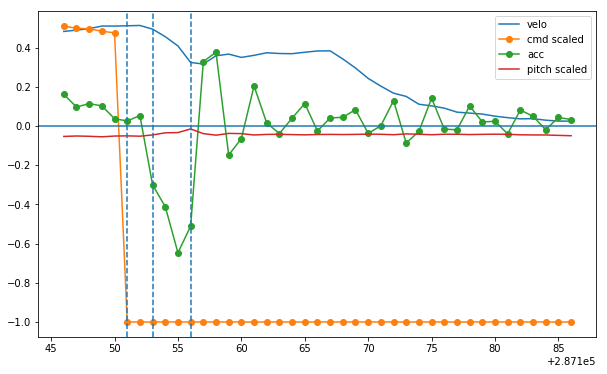

In [17]:
plot_detail(74)

# 3. One-sided outlier detection based on t-test for `acc_mean` of braking.

In [18]:
# 
tdf = len(df_brakes) - 1
tdist = stats.t(tdf)
brake_acc = df_brakes.acc_mean # mean of acc in brake
# brake_acc = df_brakes.acc_min # mean of acc in brake
#
mu = brake_acc.mean()
std = brake_acc.std()
# q = tdist.ppf(0.975)
# out_idx = abs(brake_acc - mu)/std > q
q = tdist.ppf(0.95)
out_idx = (brake_acc - mu)/std > q

Text(0.5, 0, 'timestamp')

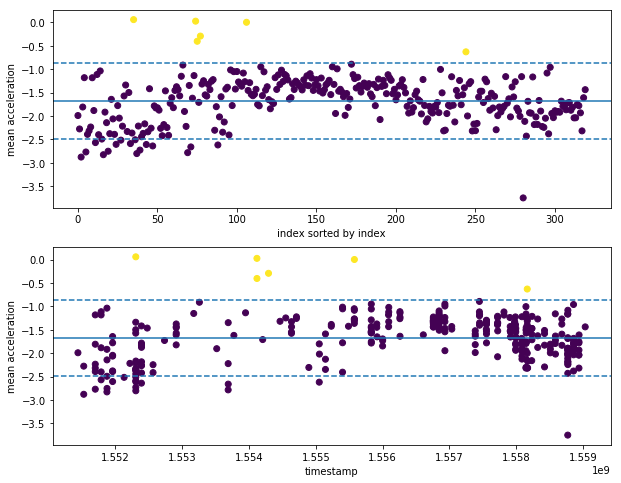

In [19]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.scatter(df_brakes.index, brake_acc, c=out_idx) # sorted by index
plt.axhline(mu)
plt.axhline(mu+q*std, linestyle = '--')
plt.axhline(mu-q*std, linestyle = '--')
plt.ylabel("mean acceleration")
plt.xlabel("index sorted by index")

plt.subplot(212)
plt.scatter(df_brakes.timestamp, brake_acc, c=out_idx) # sorted by timestamp
plt.axhline(mu)
plt.axhline(mu+q*std, linestyle = '--')
plt.axhline(mu-q*std, linestyle = '--')
plt.ylabel("mean acceleration")
plt.xlabel("timestamp")

In [20]:
df_brakes[out_idx].copy()

,v,t_total,t1,t2,t3,s_total,s1,s2,s3,acc_mean,acc_min,timestamp,time,dayofyear,month,week,bag_name,pitch_mean
35,0.331860,25,2,3,20,0.421664,0.073422,0.076322,0.271919,0.060515,-0.343664,1.552306e+09,20190311200248,70,3,10,2019_03_11_19_44_00_arts16_2,0.018859
74,0.512291,34,2,3,29,0.859923,0.101772,0.127609,0.630542,0.027584,-0.510854,1.554119e+09,20190401194009,91,4,13,2019_04_01_19_38_29_arts16_2,-0.004177
75,1.471208,37,2,3,32,2.825834,0.291735,0.416277,2.117822,-0.402090,-0.702381,1.554119e+09,20190401194726,91,4,13,2019_04_01_19_38_29_arts16_2,0.004769
77,1.187530,32,2,3,27,1.080612,0.244761,0.334252,0.501599,-0.291363,-1.933040,1.554292e+09,20190403195231,93,4,13,2019_04_03_19_48_12_arts16_2,0.003096
106,0.632452,20,2,3,15,0.370625,0.109815,0.097712,0.163098,0.003414,-0.239558,1.555578e+09,20190418165257,108,4,15,2019_04_18_16_00_52_arts16_2,-0.009903
244,0.490806,10,2,3,5,0.245159,0.096648,0.105235,0.043276,-0.627632,-2.408944,1.558164e+09,20190518152708,138,5,19,2019_05_18_15_23_29_arts16_2,0.009890


# 4. Kernel ridge for $p(acc|v, cmd=-57)$

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [22]:
n1 = len(df_brakes[~out_idx])
X1 = np.array(df_brakes[~out_idx].v).reshape(n1,1)
y1 = df_brakes[~out_idx].acc_mean

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": np.logspace(-3, 1, 5),
                              "gamma": np.logspace(-2, 2, 5)})
 
kr.fit(X1, y1)

/home/stve/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
kr.best_estimator_

KernelRidge(alpha=10.0, coef0=1, degree=3, gamma=0.01, kernel='rbf',
      kernel_params=None)

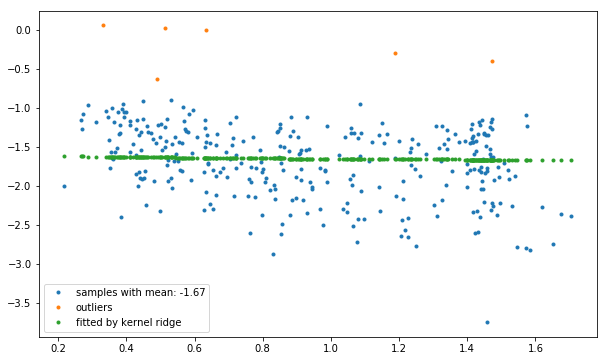

In [24]:
plt.figure(figsize=(10,6))
plt.plot(X1, y1, '.', label = 'samples with mean: %s' % np.round(mu, 2))
plt.plot(df_brakes.v[out_idx], df_brakes.acc_mean[out_idx], '.', label = 'outliers')
plt.plot(X1, kr.predict(X1), '.', label = 'fitted by kernel ridge')
plt.legend();

__It turns out that:__ the accelerations in braking are not affected significantly by the initial speed.

# 5. Model for $p(s| v, cmd = -57)$

## 5.1 Kernel ridge

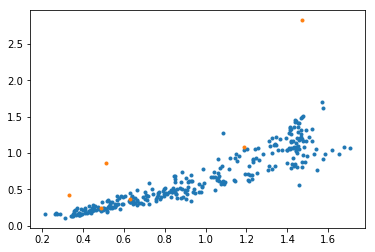

In [25]:
plt.plot(df_brakes.v[~out_idx], df_brakes.s_total[~out_idx], '.')
plt.plot(df_brakes.v[out_idx], df_brakes.s_total[out_idx], '.');
# orange dots are outliers

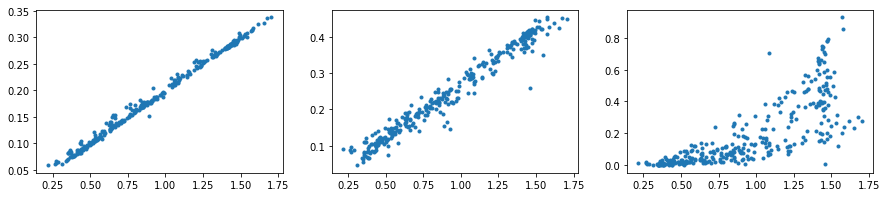

In [26]:
plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.plot(df_brakes.v[~out_idx], df_brakes.s1[~out_idx], '.')
plt.subplot(132)
plt.plot(df_brakes.v[~out_idx], df_brakes.s2[~out_idx], '.')
plt.subplot(133)
plt.plot(df_brakes.v[~out_idx], df_brakes.s3[~out_idx], '.');

In [27]:
X2 = np.array(df_brakes[~out_idx].v).reshape(n1, 1)
y2 = df_brakes[~out_idx].s_total

# polynomial kernel
kr2 = GridSearchCV(KernelRidge(kernel='polynomial', gamma=0.1, degree=3), cv=5,
                  param_grid={"alpha": np.logspace(-3, 1, 5),
                              "gamma": np.logspace(-2, 3, 6)})
 
kr2.fit(X2, y2)
kr2.best_estimator_

/home/stve/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.01, kernel='polynomial',
      kernel_params=None)

In [28]:
# th = lambda x: np.array([s if abs(s)>0.02 else 0 for s in x])
# X3 = np.c_[np.ones(n1), X2, X2**2, th(np.array(df_brakes.pitch_mean[~out_idx]))]
X3 = np.c_[np.ones(n1), X2, X2**2]

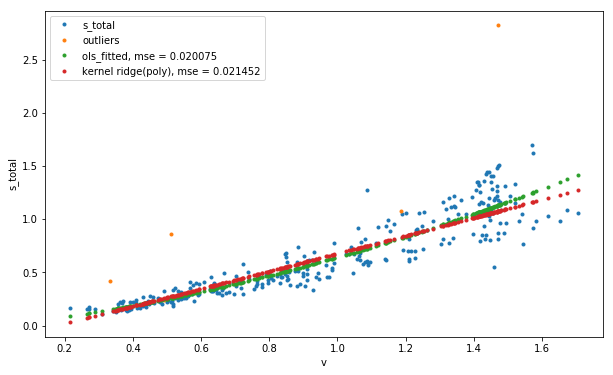

In [29]:
plt.figure(figsize=(10,6))
plt.plot(X2, y2, '.')
plt.plot(df_brakes[out_idx].v, df_brakes[out_idx].s_total, '.', label='outliers')
plt.plot(X2, X3 @ la.pinv(X3) @ y2, '.',
         label = 'ols_fitted, mse = %f'%np.mean(((X3 @ la.pinv(X3) @ y2).ravel() - y2)**2)) # directly fit with quadratic
plt.plot(X2, kr2.predict(X2), '.', label = 'kernel ridge(poly), mse = %f'%np.mean((kr2.predict(X2) - y2)**2))
plt.xlabel('v')
plt.ylabel('s_total')
plt.legend();

The residuals are apparently of fan shape, implying that the variance should be $v$-dependent, so the model can be written as

$$
s = f(v^2) + q(v)*\sigma
$$

where $\sigma\sim N(0,1)$, $f(v^2) = E(s|v)$ and $q(v)$ is the scale/level for variance given a specific intial speed $v$.

## 5.2 quantile regression (non-parametric)

<Figure size 432x288 with 0 Axes>

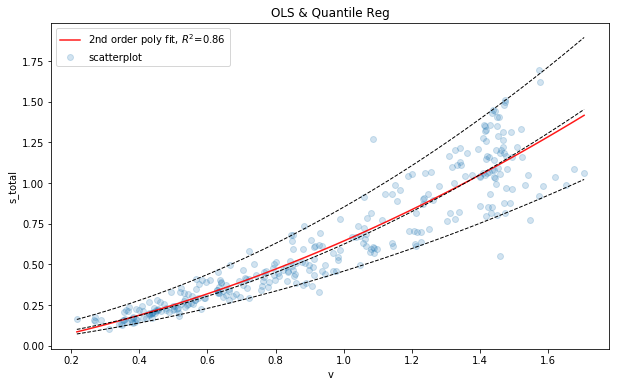

In [57]:
# Quantile reg
# Least Absolute Deviation
# The LAD model is a special case of quantile regression where q=0.5

quantiles = [.025, .50, .975]
df_qreg = pd.DataFrame({'v': X1.ravel(), 's_total':y2.ravel()})
mod = smf.quantreg('s_total ~ 1 + v + I(v ** 2.0)', df_qreg)
# get all result instances in a list
res_all = [mod.fit(q=q) for q in quantiles]

res_ols = smf.ols('s_total ~ 1 + v + I(v ** 2.0)', df_qreg).fit()


plt.figure()

# create x for prediction
x_p = np.linspace(df_qreg.v.min(), df_qreg.v.max(), 50)
df_p = pd.DataFrame({'v': x_p})
plt.figure(figsize=(10,6))
for qm, res in zip(quantiles, res_all):
    # get prediction for the model and plot
    # here we use a dict which works the same way as the df in ols
    plt.plot(x_p, res.predict({'v': x_p}), linestyle='--', lw=1, 
             color='k', zorder=2)

y_ols_predicted = res_ols.predict(df_p)
plt.plot(x_p, y_ols_predicted, color='red', zorder=1, 
         label='2nd order poly fit, $R^2$=%.2f' % res_ols.rsquared, 
         alpha=0.9)
#plt.scatter(df.temp, df.dens, alpha=.2)
plt.plot(df_qreg.v, df_qreg.s_total, 'o', alpha=.2, zorder=0, label = 'scatterplot')
#plt.legend(loc="upper center")
plt.xlabel('v')
plt.ylabel('s_total')
plt.title('OLS & Quantile Reg')
plt.legend();

# 6. Time decay over time?
### Difference across time? any decay observed?

In [31]:
def fit_curve(month, degree=2):
    """
    
    """
    
    idx_ = df_brakes[~out_idx].month == month
    x = df_brakes[~out_idx][idx_].v
    X = np.ones(len(x))
    y = df_brakes[~out_idx][idx_].s_total
    for i in range(degree):
        X = np.c_[X, x**(i+1)]
        
    x_new = np.linspace(0, 2, 20)
    X_new = np.ones(len(x_new))
    for i in range(degree):
        X_new = np.c_[X_new, x_new**(i+1)]    
    plt.plot(x_new, X_new @ la.pinv(X) @ y, alpha=0.3, label=month)
    plt.legend()

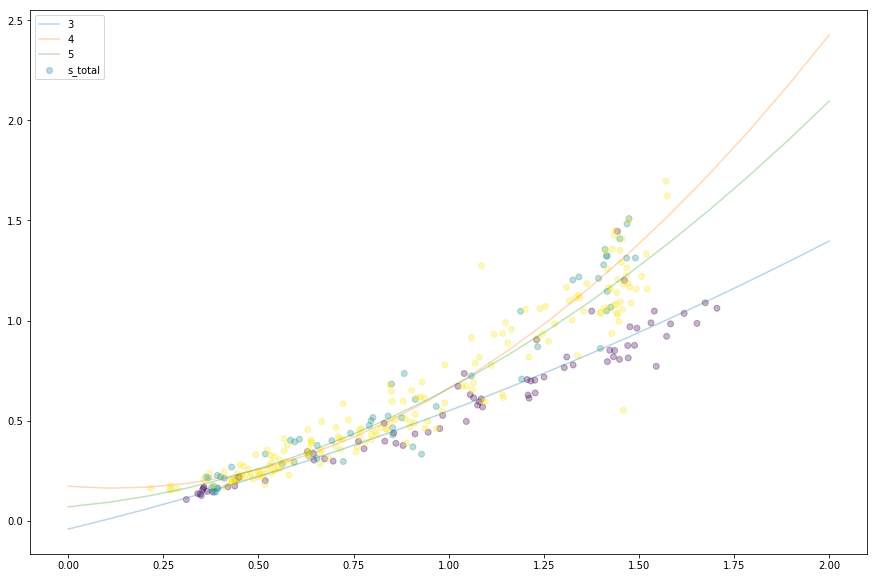

In [32]:
plt.figure(figsize=(15,10))
plt.scatter(df_brakes.v[~out_idx], df_brakes.s_total[~out_idx], alpha=0.3, c=df_brakes.month[~out_idx])
fit_curve(3)
fit_curve(4)
fit_curve(5)

### Brake time/distance by dayofyear

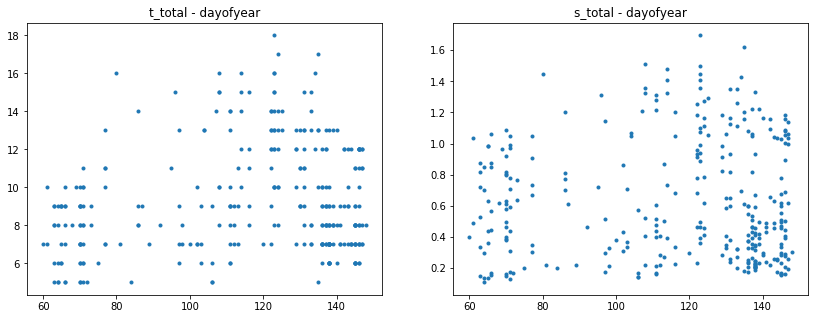

In [33]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(df_brakes.dayofyear[~out_idx], df_brakes.t_total[~out_idx], '.')
plt.title('t_total - dayofyear')
plt.subplot(122)
plt.plot(df_brakes.dayofyear[~out_idx], df_brakes.s_total[~out_idx], '.')
plt.title('s_total - dayofyear');

### Acceleration-dayofyear/weekofyear by month

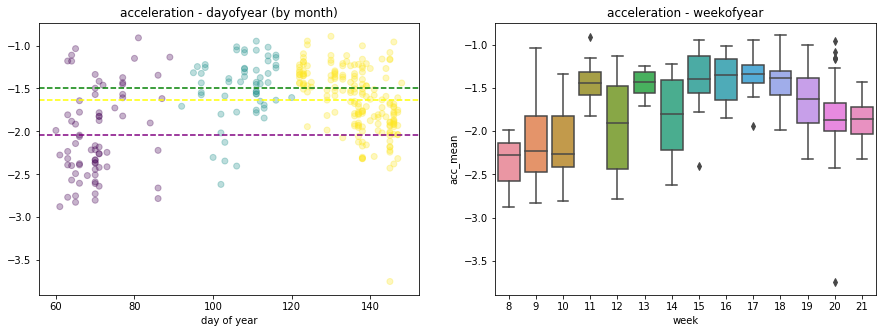

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(df_brakes.dayofyear[~out_idx], df_brakes.acc_mean[~out_idx], c=df_brakes.month[~out_idx], alpha = 0.3)
plt.axhline(np.mean(df_brakes.acc_mean[~out_idx][df_brakes.month[~out_idx]==3]), c='purple', linestyle='--')
plt.axhline(np.mean(df_brakes.acc_mean[~out_idx][df_brakes.month[~out_idx]==4]), c='green', linestyle='--')
plt.axhline(np.mean(df_brakes.acc_mean[~out_idx][df_brakes.month[~out_idx]==5]), c='yellow', linestyle='--')
plt.xlabel('day of year')
plt.title("acceleration - dayofyear (by month)")
plt.subplot(122)
sns.boxplot('week', 'acc_mean', data=df_brakes[~out_idx])
plt.title("acceleration - weekofyear");

# 7. Pitch's influence
### T-test

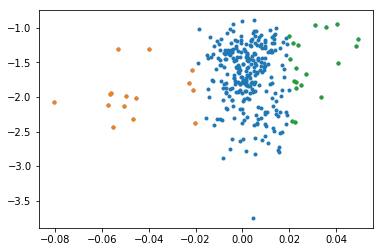

In [35]:
plt.plot(df_brakes.pitch_mean[~out_idx], df_brakes.acc_mean[~out_idx], '.')
plt.plot(df_brakes.pitch_mean[~out_idx][df_brakes.pitch_mean[~out_idx]<-0.02],df_brakes.acc_mean[~out_idx][df_brakes.pitch_mean[~out_idx]<-0.02], '.')
plt.plot(df_brakes.pitch_mean[~out_idx][df_brakes.pitch_mean[~out_idx]>0.02],df_brakes.acc_mean[~out_idx][df_brakes.pitch_mean[~out_idx]>0.02], '.')

In [36]:
x1 = df_brakes.acc_mean[~out_idx][df_brakes.pitch_mean[~out_idx]<-0.02]
m1 = x1.mean()
s1 = x1.std()
n1 = len(x1)
x2 = df_brakes.acc_mean[~out_idx][df_brakes.pitch_mean[~out_idx]>0.02]
m2 = x2.mean()
s2 = x2.std()
n2 = len(x2)

In [37]:
# t-test for pitch's influence
(m1-m2)/np.sqrt((s1**2*(n1-1)+s2**2*(n2-1))/(n1+n2-2)*(1/n1+1/n2))

-3.0650353097044976

### Visualization for pitch

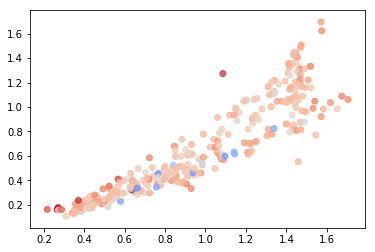

In [38]:
plt.scatter(df_brakes.v[~out_idx], df_brakes.s_total[~out_idx], alpha=0.8, c=df_brakes.pitch_mean[~out_idx], cmap='coolwarm')

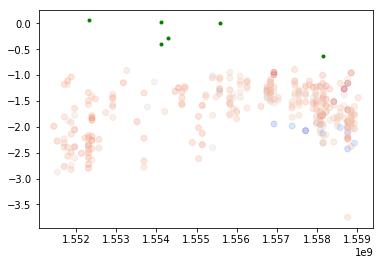

In [39]:
plt.scatter(df_brakes[~out_idx].timestamp, df_brakes[~out_idx].acc_mean, c=df_brakes[~out_idx].pitch_mean, cmap='coolwarm', alpha=0.3)
plt.plot(df_brakes[out_idx].timestamp, df_brakes[out_idx].acc_mean, '.', c='green')

In [226]:
# df_brakes[out_idx]
# plot_detail(75, 50, 50)